In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found 3910 images belonging to 2 classes.
Found 976 images belonging to 2 classes.


I0000 00:00:1744557140.627560      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744557152.881843     103 service.cc:148] XLA service 0x78e93400f5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744557152.882753     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744557153.271738     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/123 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.5781 - loss: 0.8884  

I0000 00:00:1744557161.932334     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/123 ━━━━━━━━━━━━━━━━━━━━ 102s 711ms/step - accuracy: 0.7483 - loss: 0.6531 - val_accuracy: 0.5820 - val_loss: 1.1781 - learning_rate: 1.0000e-04
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 67s 517ms/step - accuracy: 0.8490 - loss: 0.3922 - val_accuracy: 0.6148 - val_loss: 1.2864 - learning_rate: 1.0000e-04
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 513ms/step - accuracy: 0.8739 - loss: 0.3430 - val_accuracy: 0.7428 - val_loss: 0.8287 - learning_rate: 1.0000e-04
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 511ms/step - accuracy: 0.8701 - loss: 0.3238 - val_accuracy: 0.7254 - val_loss: 0.9108 - learning_rate: 1.0000e-04
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 513ms/step - accuracy: 0.8899 - loss: 0.2895 - val_accuracy: 0.7029 - val_loss: 1.0719 - learning_rate: 1.0000e-04
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8904 - loss: 0.3043
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 515ms/step - accur

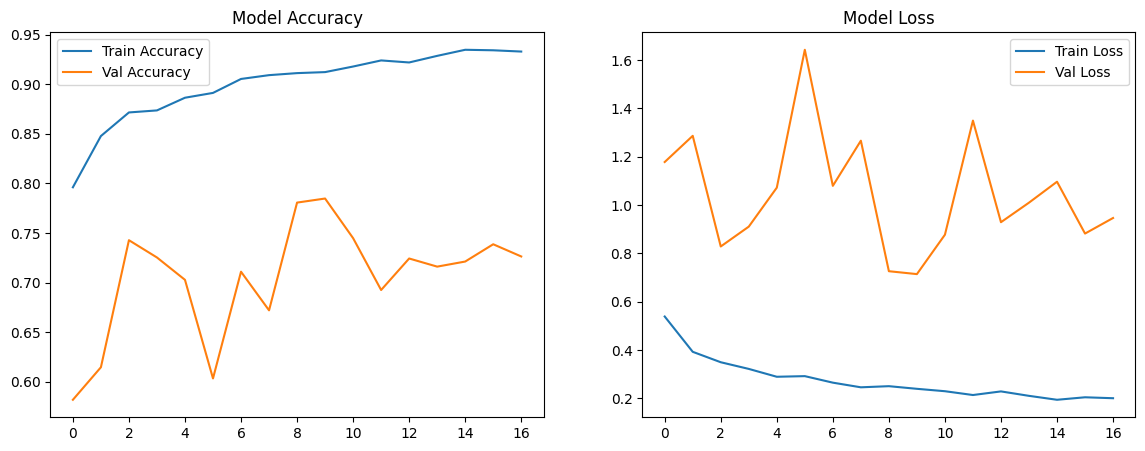


✅ Final Validation Accuracy: 0.73
📁 Model saved successfully as 'vgg16_steganography_model.keras'


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dataset path
dataset_path = '/kaggle/input/steganography'

# Image Preprocessing & Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load VGG16 without top layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train model
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop, lr_reduce]
)

# Plot performance
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# Final Validation Accuracy
val_acc = history.history['val_accuracy'][-1]
print(f"\n✅ Final Validation Accuracy: {val_acc:.2f}")

# Save model
model.save('vgg16_steganography_model.keras')
print("📁 Model saved successfully as 'vgg16_steganography_model.keras'")


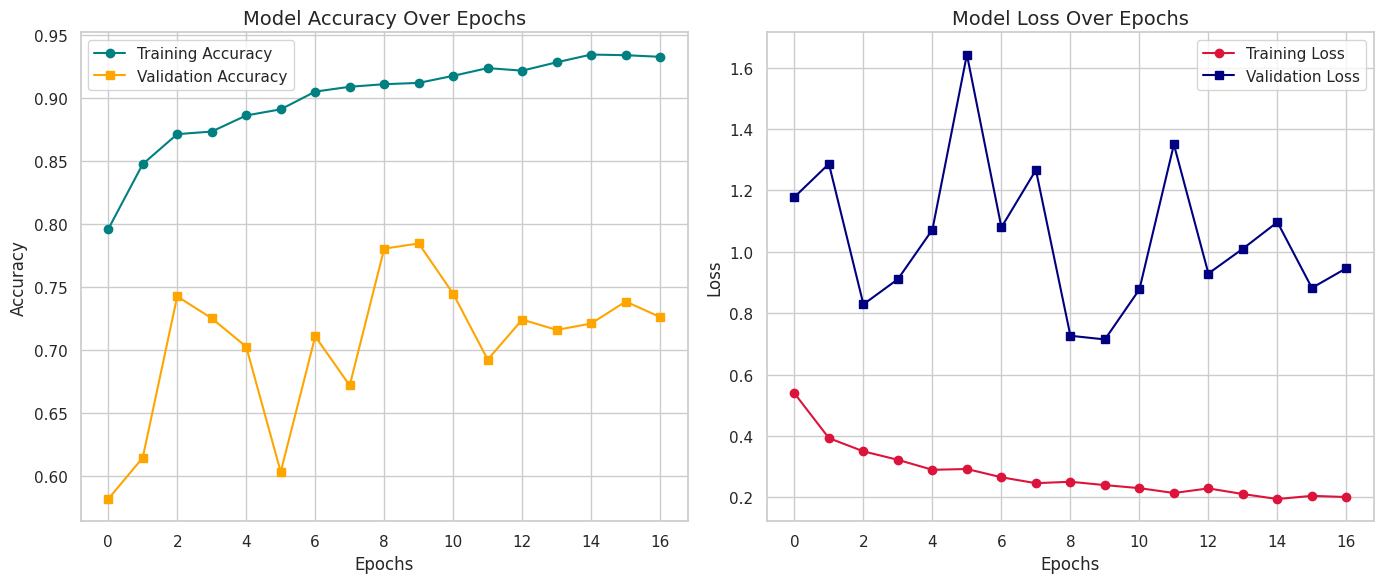

In [3]:
import seaborn as sns

# Set Seaborn style for better visuals
sns.set(style="whitegrid")

# Accuracy Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Training Accuracy', color='teal')
plt.plot(history.history['val_accuracy'], marker='s', label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Training Loss', color='crimson')
plt.plot(history.history['val_loss'], marker='s', label='Validation Loss', color='navy')
plt.title('Model Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step


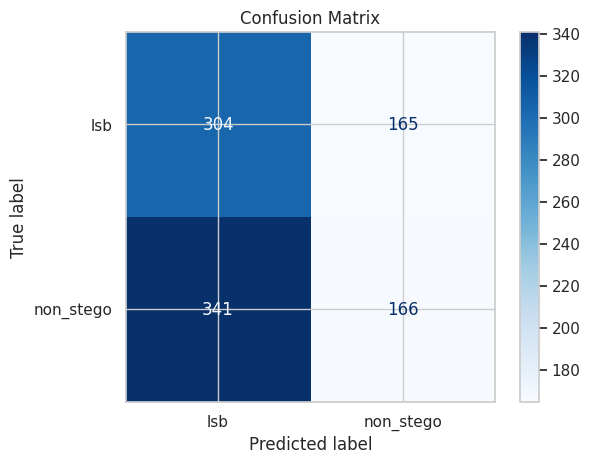


🔍 Classification Report:

              precision    recall  f1-score   support

         lsb       0.47      0.65      0.55       469
   non_stego       0.50      0.33      0.40       507

    accuracy                           0.48       976
   macro avg       0.49      0.49      0.47       976
weighted avg       0.49      0.48      0.47       976



In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))


In [5]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_gen, verbose=1)

print(f"\n📊 Validation Loss: {val_loss:.4f}")
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 412ms/step - accuracy: 0.7647 - loss: 0.7363

📊 Validation Loss: 0.7870
✅ Validation Accuracy: 0.7633


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dataset path
dataset_path = '/kaggle/input/steganography'

# Image Preprocessing & Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load VGG16 without top layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all layers except the last 4
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(2, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop, lr_reduce]
)

# Save model
model.save('vgg16_finetuned_steganography.keras')
print("📁 Model saved successfully as 'vgg16_finetuned_steganography.keras'")


Found 3910 images belonging to 2 classes.
Found 976 images belonging to 2 classes.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 83s 597ms/step - accuracy: 0.6955 - loss: 0.8958 - val_accuracy: 0.6004 - val_loss: 0.8241 - learning_rate: 1.0000e-04
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 75s 580ms/step - accuracy: 0.8135 - loss: 0.6094 - val_accuracy: 0.5092 - val_loss: 1.2881 - learning_rate: 1.0000e-04
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 74s 575ms/step - accuracy: 0.8458 - loss: 0.5129 - val_accuracy: 0.7029 - val_loss: 1.0147 - learning_rate: 1.0000e-04
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.8785 - loss: 0.4373
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
123/123 ━━━━━━━━━━━━━━━━━━━━ 74s 574ms/step - accuracy: 0.8785 - loss: 0.4372 - val_accuracy: 0.6178 - val_loss: 1.7442 - learning_rate: 1.0000e-04
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 74s 576ms/step - accuracy: 0.9043 - loss: 0.3619 - val_accuracy: 0.6906 - val_loss: 1.1968 - learning_rate: 5.0000e-05
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 74s 574ms/step - accura

In [7]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_gen, verbose=1)

print(f"\n📊 Validation Loss: {val_loss:.4f}")
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")



31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 467ms/step - accuracy: 0.5933 - loss: 0.8391

📊 Validation Loss: 0.8237
✅ Validation Accuracy: 0.6004


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - accuracy: 0.5896 - loss: 0.8241

✅ Final Validation Accuracy: 0.60
🧮 Final Validation Loss: 0.82


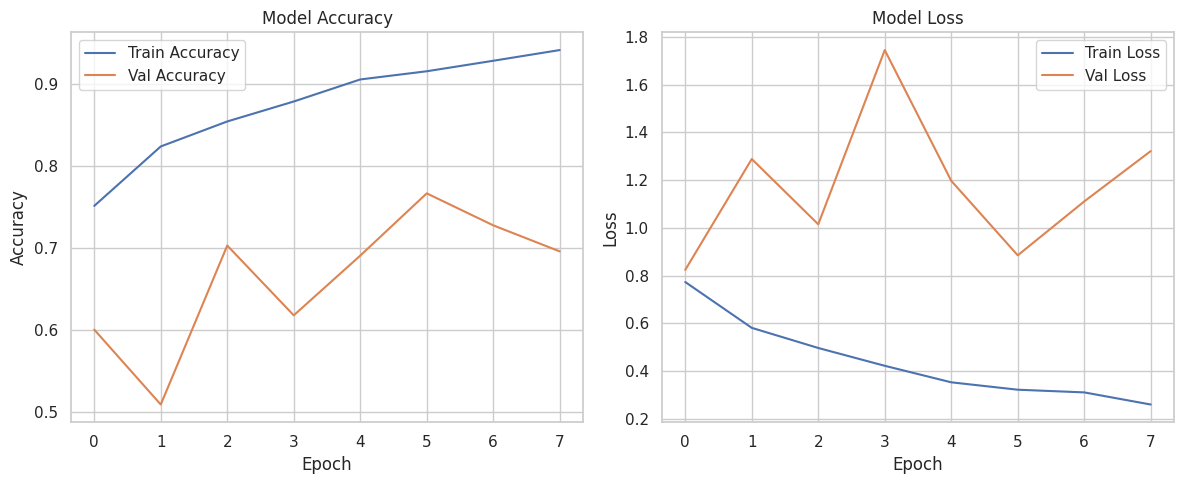

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step


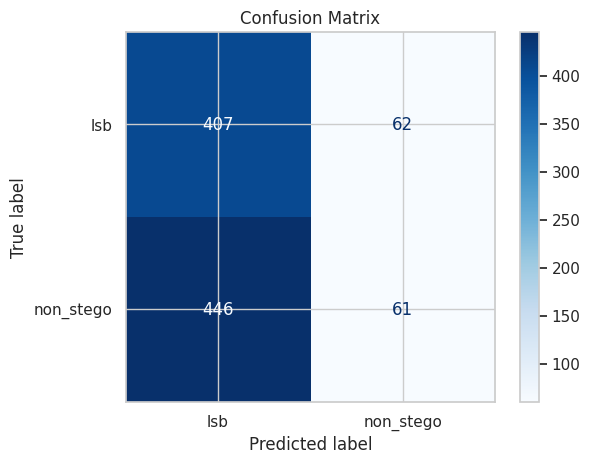


📊 Classification Report:

              precision    recall  f1-score   support

         lsb       0.48      0.87      0.62       469
   non_stego       0.50      0.12      0.19       507

    accuracy                           0.48       976
   macro avg       0.49      0.49      0.40       976
weighted avg       0.49      0.48      0.40       976



In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Evaluate model
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {val_acc:.2f}")
print(f"🧮 Final Validation Loss: {val_loss:.2f}")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
# Get predictions
val_gen.reset()
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))



Found 3910 images belonging to 2 classes.
Found 976 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 530ms/step - accuracy: 0.8355 - loss: 0.6811 - val_accuracy: 0.6639 - val_loss: 0.8385 - learning_rate: 1.0000e-05
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 513ms/step - accuracy: 0.8493 - loss: 0.6470 - val_accuracy: 0.7346 - val_loss: 0.8263 - learning_rate: 1.0000e-05
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 516ms/step - accuracy: 0.8707 - loss: 0.6104 - val_accuracy: 0.7541 - val_loss: 0.8247 - learning_rate: 1.0000e-05
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 509ms/step - accuracy: 0.8780 - loss: 0.5816 - val_accuracy: 0.7602 - val_loss: 0.8296 - learning_rate: 1.0000e-05
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 511ms/step - accuracy: 0.8873 - loss: 0.5785 - val_accuracy: 0.7695 - val_loss: 0.8337 - learning_rate: 1.0000e-05
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 510ms/step - accuracy: 0.8858 - loss: 0.5669 - val_accuracy: 0.7705 - val_loss: 0.8518 - learning_rate: 1.0000e-05
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - a

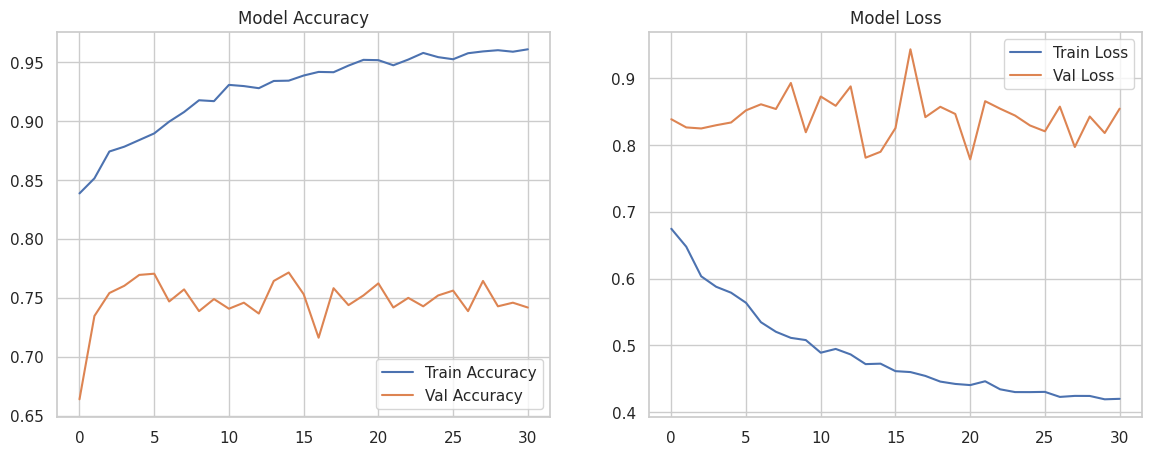


🎯 Final Validation Accuracy after fine-tuning: 74.18%


In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Paths
dataset_path = '/kaggle/input/steganography'
model_path = '/kaggle/working/vgg16_finetuned_steganography.keras'

# Load previous model
model = load_model(model_path)

# Unfreeze last few layers in VGG16 base model
base_model = model.layers[0]  # VGG16 is the first layer
for layer in base_model.layers[-4:]:  # unfreezing last 4 conv layers
    layer.trainable = True

# Re-compile with lower LR and label smoothing
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # lower LR for fine-tuning
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Augmentation and Data Prep
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

# Train again
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[early_stop, lr_reduce]
)

# Save fine-tuned model
model.save('vgg16_finetuned_v2_steganography.keras')
print("✅ Fine-tuned model saved as 'vgg16_finetuned_v2_steganography.keras'")

# Plotting performance
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# Final Accuracy
final_val_acc = history.history['val_accuracy'][-1]
print(f"\n🎯 Final Validation Accuracy after fine-tuning: {final_val_acc:.2%}")
